# Simulation to test cost functions for probabilistic path finding

This notebook is a repsonse to https://github.com/ElementsProject/lightning/pull/4771 where Rusty Russel, Christian Decker and I discuss which cost function should be used in Sijkstra computations to test single paths if one wants to incorporate the results from proababilistic path finding research (c.f: https://arxiv.org/abs/2103.08576 )

## Funding
This work is funded by NTNU, Bitmex, and independent people tipping me via https://donate.ln.rene-pickhardt.de and via https://patreon.com/renepickhardt

In [1]:
import json
from math import log2
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

## A few helper functions

In [2]:
def import_channels(filename):
    f= open(filename,"r")
    channels = json.load(f)["channels"]
    return channels

def arithmetic_mean(features):
    return np.mean(features)

def harmonic_mean(features):
    return len(features)/sum(1.0/f for f in features)



## Define cost functions for single features that are potentially used in c-lighting

In [3]:
def fee_function(amt,channel):
    return channel["base_fee_millisatoshi"]+amt*channel["fee_per_millionth"]/1000000
    
def risk_factor_cltv(riskfactor,channel):
    cltv_delay = channel["delay"]
    BLOCKS_PER_YEAR = 144*365
    return riskfactor / 100.0 / BLOCKS_PER_YEAR * cltv_delay
    
def neg_log_probabilities(amt, channel):
    cap = channel["satoshis"]*1000
    return -log2((cap+1-amt)/(cap+1))
    
def linearized_success_probabilities(amt,channel):
    cap = channel["satoshis"]*1000
    return amt/(cap+1)


## Actual cost functions with combination of features 

In [4]:
def build_features(amt, channel, risk_factor=0):
    features = {
        "fees":fee_function(amt,channel),
        "neg_log_prob":neg_log_probabilities(amt, channel)}
    if risk_factor>0:
        features["risk_factor"]= risk_factor_cltv(risk_factor,channel)
    return features
    
    
def harmonic_probabilistic_cost(amt,channel,risk_factor=0):
    features = build_features(amt,channel,risk_factor)
    return harmonic_mean(features.values())

def arithmetic_probabilistic_cost(amt,channel,risk_factor=0):
    features = build_features(amt,channel,risk_factor)
    return arithmetic_mean(list(features.values()))

def rusty_proposed_cost(amt,channel,risk_factor=0):
    f = fee_function(amt,channel)
    p = linearized_success_probabilities(amt,channel)
    r = risk_factor_cltv(risk_factor,channel)
    return f*(1+p)+r


## Import data from lightning-cli listchannels > channels20210918.json

In [5]:
channels = import_channels("channels20210918.json")
channels[0]

{'active': True,
 'amount_msat': '20000000msat',
 'base_fee_millisatoshi': 0,
 'channel_flags': 0,
 'delay': 144,
 'destination': '03fab7f8655169ea77d9691d4bd359e97782cb6177a6f76383994ed9c262af97a5',
 'features': '',
 'fee_per_millionth': 1,
 'htlc_maximum_msat': '20000000msat',
 'htlc_minimum_msat': '1000msat',
 'last_update': 1631699351,
 'message_flags': 1,
 'public': True,
 'satoshis': 20000,
 'short_channel_id': '513909x1248x0',
 'source': '02ad6fb8d693dc1e4569bcedefadf5f72a931ae027dc0f0c544b34c1c6f3b9a02b'}

## Plot Diagrams

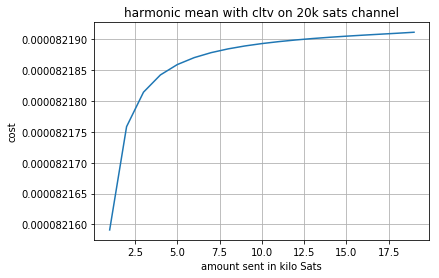

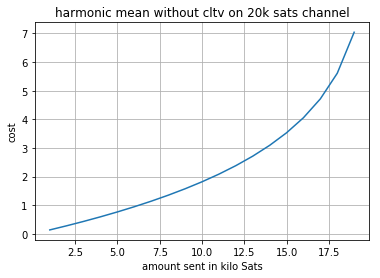

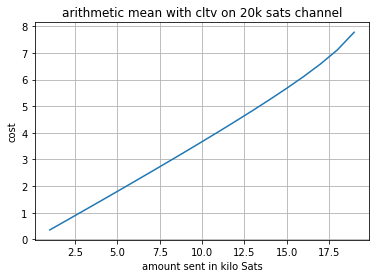

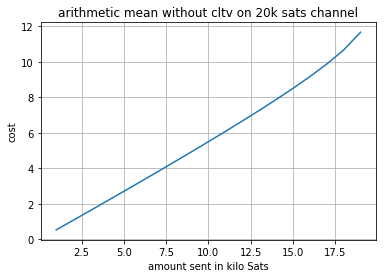

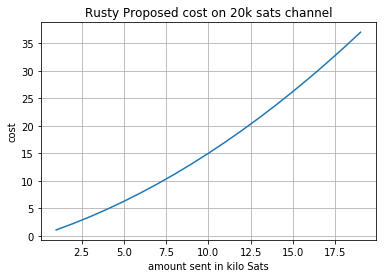

In [6]:
values = list(range(1,20))

plt.title("harmonic mean with cltv on 20k sats channel")
plt.plot(values,[harmonic_probabilistic_cost(amt*1000000,channels[0],1) for amt in values])
plt.grid()
plt.xlabel("amount sent in kilo Sats")
plt.ylabel("cost")
plt.show()
plt.title("harmonic mean without cltv on 20k sats channel")
plt.plot(values,[harmonic_probabilistic_cost(amt*1000000,channels[0]) for amt in values])
plt.grid()
plt.xlabel("amount sent in kilo Sats")
plt.ylabel("cost")
plt.show()
plt.title("arithmetic mean with cltv on 20k sats channel")
plt.plot(values,[arithmetic_probabilistic_cost(amt*1000000,channels[0],1) for amt in values])
plt.grid()
plt.xlabel("amount sent in kilo Sats")
plt.ylabel("cost")
plt.show()
plt.title("arithmetic mean without cltv on 20k sats channel")
plt.plot(values,[arithmetic_probabilistic_cost(amt*1000000,channels[0]) for amt in values])
plt.grid()
plt.xlabel("amount sent in kilo Sats")
plt.ylabel("cost")
plt.show()
plt.title("Rusty Proposed cost on 20k sats channel")
plt.plot(values,[rusty_proposed_cost(amt*1000000,channels[0]) for amt in values])
plt.grid()
plt.xlabel("amount sent in kilo Sats")
plt.ylabel("cost")
plt.show()